## Dataset Loading

Load real-world benchmark datasets for empirical evaluation.

In [2]:
# Import necessary libraries for real-world dataset processing
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
import psutil
import gc
from collections import deque
import sys
import os
import random

from scipy.stats import ks_2samp, wasserstein_distance
from scipy.io import arff  # For loading ARFF files (Airlines dataset)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from river import datasets

# Load from ARFF file
from scipy.io import arff

# Setup paths for local modules
sys.path.insert(0, os.path.abspath('../backup'))
# Random seed configuration
RANDOM_SEED = random.randint(0, 1000000)

# Import drift detection methods (from backup folder)
from shape_dd import shape, shape_adaptive
from dawidd import dawidd
from d3 import d3
from ks import ks
from mmd import mmd


In [3]:
# Methods to evaluate
window_methods = [
    'D3', 
    'DAWIDD', 
    'ShapeDD',              
    'ShapeDD_Improved',      
]

streaming_methods = [
    'ADWIN',
    'DDM', 
    'EDDM', 
    'HDDM_A', 
    'HDDM_W', 
    'FHDDM'
    ]


In [4]:
def monitor_resources():
    """Monitor memory usage."""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb


In [22]:
def load_datasets(synthetic_size=60000, seed=RANDOM_SEED):
    datasets_dict = {}
        
    # --- Electricity (Elec2) Dataset ---
    print("  Loading Electricity (Elec2) dataset")
    df_elec2 = pd.read_csv('../datasets/electricity.csv')
    X_elec2 = df_elec2.drop(columns=['class']).to_numpy()
    y_elec2 = df_elec2['class'].to_numpy()
    
    datasets_dict['Electricity'] = {
        'name': 'Electricity',
        'X': X_elec2,
        'y': y_elec2,
        'drift_points': None,  # Unknown drift locations
        'drift_type': 'unknown',
        'description': 'Electricity price prediction dataset with concept drift'
    }
    print(f"Electricity: {X_elec2.shape[0]:,} samples, {X_elec2.shape[1]} features")
    
    # --- Airlines Dataset ---
    print("  Loading Airlines dataset")
    # Try to load from CSV first, then ARFF if needed
    try:
        df_airline = pd.read_csv('../datasets/airlines.csv')
    except:
        data, meta = arff.loadarff('../datasets/airlines.arff')
        df_airline = pd.DataFrame(data)
        
        # Decode byte strings if present
        for col in df_airline.columns:
            if df_airline[col].dtype == object:
                try:
                    df_airline[col] = df_airline[col].str.decode('utf-8')
                except:
                    pass
    
    # Identify target column (usually 'class' or 'delay')
    target_col = None
    for col in ['class', 'delay', 'Delay']:
        if col in df_airline.columns:
            target_col = col
            break
    
    if target_col:
        # Convert categorical features to numeric
        df_airline_numeric = df_airline.copy()
        for col in df_airline_numeric.columns:
            if df_airline_numeric[col].dtype == object:
                df_airline_numeric[col] = pd.Categorical(df_airline_numeric[col]).codes
        
        X_airline = df_airline_numeric.drop(columns=[target_col]).to_numpy()
        y_airline = df_airline_numeric[target_col].to_numpy()
    else:
        # If no clear target, use all features for drift detection
        df_airline_numeric = df_airline.copy()
        for col in df_airline_numeric.columns:
            if df_airline_numeric[col].dtype == object:
                df_airline_numeric[col] = pd.Categorical(df_airline_numeric[col]).codes
        
        X_airline = df_airline_numeric.to_numpy()
        y_airline = np.zeros(len(X_airline))  # Dummy labels
    
    datasets_dict['Airlines'] = {
        'name': 'Airlines',
        'X': X_airline,
        'y': y_airline,
        'drift_points': None,  # Unknown drift locations
        'drift_type': 'unknown',
        'description': 'Flight delay prediction with seasonal patterns'
    }
    print(f"Airlines: {X_airline.shape[0]:,} samples, {X_airline.shape[1]} features")
        
    # --- SEA Dataset (Abrupt Drift) ---
    print("  Generating SEA dataset (abrupt drift)...")
    from river.datasets import synth
    
    # SEA has 4 concepts/variants: 0, 1, 2, 3
    drift_points_sea = [synthetic_size//4, synthetic_size//2, 3*synthetic_size//4]
    
    X_sea_list, y_sea_list = [], []
    
    variants = [0, 1, 2, 3]
    segment_boundaries = [0] + drift_points_sea + [synthetic_size]
    
    for seg_idx in range(len(variants)):
        start_idx = segment_boundaries[seg_idx]
        end_idx = segment_boundaries[seg_idx + 1]
        segment_size = end_idx - start_idx
        
        # Create stream with specific variant for this segment
        stream = synth.SEA(seed=RANDOM_SEED, variant=variants[seg_idx])
        
        for i, (x, y) in enumerate(stream.take(segment_size)):
            X_sea_list.append(list(x.values()))
            y_sea_list.append(y)
    
    X_sea = np.array(X_sea_list)
    y_sea = np.array(y_sea_list)
    
    datasets_dict['SEA'] = {
        'name': 'SEA',
        'X': X_sea,
        'y': y_sea,
        'drift_points': drift_points_sea,
        'drift_type': 'abrupt',
        'description': 'SEA concepts with abrupt drift at regular intervals'
    }
    print(f"SEA: {X_sea.shape[0]:,} samples, {X_sea.shape[1]} features")
    print(f"Drift points: {drift_points_sea}")
    
    # --- Hyperplane Dataset (Gradual Drift) ---
    print("  Generating Hyperplane dataset (gradual drift)...")
    from river.datasets import synth
    
    # Hyperplane with gradual drift - rotation every 10000 samples
    drift_points_hyperplane = list(range(10000, synthetic_size, 10000))
    
    X_hyp_list, y_hyp_list = [], []
    # mag_change controls drift magnitude, sigma controls noise
    stream = synth.Hyperplane(seed=RANDOM_SEED, n_features=10, n_drift_features=2, 
                                mag_change=0.001, noise_percentage=0.1)
    for i, (x, y) in enumerate(stream.take(synthetic_size)):
        X_hyp_list.append(list(x.values()))
        y_hyp_list.append(y)
    
    X_hyp = np.array(X_hyp_list)
    y_hyp = np.array(y_hyp_list)
    
    datasets_dict['Hyperplane'] = {
        'name': 'Hyperplane',
        'X': X_hyp,
        'y': y_hyp,
        'drift_points': drift_points_hyperplane,
        'drift_type': 'gradual',
        'description': 'Rotating hyperplane with gradual continuous drift'
    }
    print(f"Hyperplane: {X_hyp.shape[0]:,} samples, {X_hyp.shape[1]} features")
    print(f"Drift points: {drift_points_hyperplane}")
    
    # --- LED Dataset (Abrupt Drift) ---
    print("  Generating LED dataset (abrupt drift)...")
    from river.datasets import synth
    
    # LED with abrupt drift at 1/3 and 2/3 points
    drift_points_led = [synthetic_size // 3, 2 * synthetic_size // 3]
    
    X_led_list, y_led_list = [], []
    # We'll simulate drift by changing noise level at drift points
    for i in range(synthetic_size):
        if i < drift_points_led[0]:
            noise = 0.0  # Concept 1: no noise
        elif i < drift_points_led[1]:
            noise = 0.1  # Concept 2: 10% noise
        else:
            noise = 0.2  # Concept 3: 20% noise
        
        stream = synth.LED(seed=RANDOM_SEED + i, noise_percentage=noise)
        x, y = next(iter(stream.take(1)))
        X_led_list.append(list(x.values()))
        y_led_list.append(y)
    
    X_led = np.array(X_led_list)
    y_led = np.array(y_led_list)
    
    datasets_dict['LED'] = {
        'name': 'LED',
        'X': X_led,
        'y': y_led,
        'drift_points': drift_points_led,
        'drift_type': 'abrupt',
        'description': 'LED display with abrupt drift (changing noise levels)'
    }
    print(f"LED: {X_led.shape[0]:,} samples, {X_led.shape[1]} features")
    print(f"Drift points: {drift_points_led}")
    
    return datasets_dict


In [30]:
def visualize_stream(dataset_info, sample_rate=100, figsize=(15, 6)):
    X = dataset_info['X']
    y = dataset_info['y']
    drift_points = dataset_info['drift_points']
    name = dataset_info['name']
    
    # Sample data for visualization
    indices = np.arange(0, len(X), sample_rate)
    X_sample = X[indices]
    y_sample = y[indices]
    
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Plot 1: First two features over time
    if X.shape[1] > 1:
        # Use first two features for visualization
        feature_values_1 = X_sample[:, 0]
        feature_values_2 = X_sample[:, 1] if X.shape[1] > 1 else X_sample[:, 0]
        feature_label = 'Features 1 & 2'
    else:
        feature_values_1 = X_sample.flatten()
        feature_values_2 = X_sample.flatten()
        feature_label = 'Feature Value'
    
    axes[0].plot(indices, feature_values_1, 'b-', alpha=0.6, linewidth=0.8)
    axes[0].plot(indices, feature_values_2, 'g-', alpha=0.6, linewidth=0.8)
    axes[0].set_ylabel(feature_label, fontsize=11)
    axes[0].set_title(f'{name} Dataset - Data Stream Visualization', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Mark drift points
    if drift_points:
        for dp in drift_points:
            axes[0].axvline(x=dp, color='red', linestyle='--', linewidth=2, alpha=0.7, label='True Drift')
        # Remove duplicate labels
        handles, labels = axes[0].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axes[0].legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Plot 2: Label distribution over time (classification accuracy)
    if len(np.unique(y)) <= 10:  # Only for classification problems
        axes[1].scatter(indices, y_sample, c=y_sample, cmap='viridis', alpha=0.5, s=10)
        axes[1].set_ylabel('Class Label', fontsize=11)
    else:
        axes[1].plot(indices, y_sample, 'g-', alpha=0.6, linewidth=0.8)
        axes[1].set_ylabel('Target Value', fontsize=11)
    
    axes[1].set_xlabel('Sample Index', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Mark drift points on second plot too
    if drift_points:
        for dp in drift_points:
            axes[1].axvline(x=dp, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Optional: Quick visualization of one dataset
# Uncomment to visualize a specific dataset:
# visualize_stream(benchmark_datasets['SEA'], sample_rate=50)


In [24]:
# Load all datasets using the benchmark function
benchmark_datasets = load_datasets(synthetic_size=6000, seed=RANDOM_SEED)

for name, dataset in benchmark_datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {dataset['X'].shape[0]:,} samples × {dataset['X'].shape[1]} features")
    print(f"  Type: {dataset['drift_type'].upper()}")
    print(f"  Description: {dataset['description']}")
    if dataset['drift_points']:
        print(f"  Ground-truth drift points: {dataset['drift_points']}")
        print(f"  Number of concepts: {len(dataset['drift_points']) + 1}")


  Loading Electricity (Elec2) dataset
Electricity: 45,312 samples, 8 features
  Loading Airlines dataset
Airlines: 539,383 samples, 7 features
  Generating SEA dataset (abrupt drift)...
SEA: 6,000 samples, 3 features
Drift points: [1500, 3000, 4500]
  Generating Hyperplane dataset (gradual drift)...
Hyperplane: 6,000 samples, 10 features
Drift points: []
  Generating LED dataset (abrupt drift)...
LED: 6,000 samples, 7 features
Drift points: [2000, 4000]

Electricity:
  Shape: 45,312 samples × 8 features
  Type: UNKNOWN
  Description: Electricity price prediction dataset with concept drift

Airlines:
  Shape: 539,383 samples × 7 features
  Type: UNKNOWN
  Description: Flight delay prediction with seasonal patterns

SEA:
  Shape: 6,000 samples × 3 features
  Type: ABRUPT
  Description: SEA concepts with abrupt drift at regular intervals
  Ground-truth drift points: [1500, 3000, 4500]
  Number of concepts: 4

Hyperplane:
  Shape: 6,000 samples × 10 features
  Type: GRADUAL
  Description: 

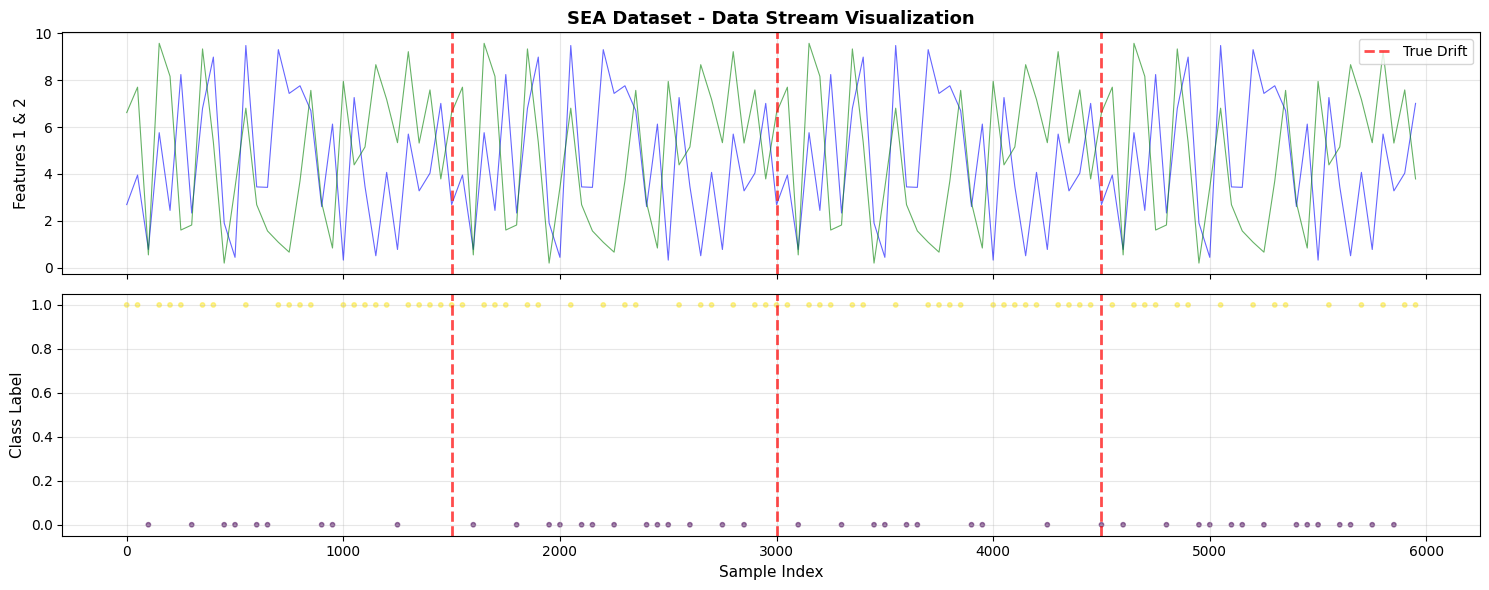

In [32]:
visualize_stream(benchmark_datasets['SEA'], sample_rate=50)


In [ ]:
# Helper Function: Window-Based Method Evaluation

def evaluate_window_based_method_batched(X, method_name, batch_size=1000, chunk_size=150, overlap=100, 
                                          d3_threshold=0.5, dawidd_alpha=0.05, shape_alpha=0.05):
    start_time = time.perf_counter()
    start_memory = monitor_resources()
    
    all_detections = []
    total_samples = len(X)
    cooldown = chunk_size // 2
    last_det = -10**9
    
    if method_name in ['ShapeDD', 'ShapeDD_Improved']:
        overlap_size = int(batch_size * 0.1)  # 10% overlap between batches
        step_size = batch_size - overlap_size
        batch_count = 0
        
        for batch_idx in range(0, total_samples, step_size):
            end_idx = min(batch_idx + batch_size, total_samples)
            batch_data = X[batch_idx:end_idx]
            
            if len(batch_data) < 100:  # Skip very small batches
                continue
            
            batch_count += 1
            local_detections = []
            
            # Run ShapeDD on this batch
            if method_name == 'ShapeDD':
                L1 = 50
                L2 = min(250, len(batch_data))
                shape_result = shape(batch_data, L1, L2, 2500)
            elif method_name == 'ShapeDD_Improved':
                L1 = max(50, int(0.05 * len(batch_data)))
                L2 = min(len(batch_data), 2 * L1)
                shape_result = shape_adaptive(batch_data, L1, L2, 2500, sensitivity='none')
            
            # Find detections in this batch
            if len(shape_result) > 0:
                p_values = shape_result[:, 2]
                detection_mask = p_values < shape_alpha
                local_detections = np.where(detection_mask)[0]
                
                # Convert to global coordinates and apply cooldown
                for local_idx in local_detections:
                    global_idx = batch_idx + local_idx
                    if global_idx - last_det >= cooldown:
                        all_detections.append(global_idx)
                        last_det = global_idx
    
    # === OTHER METHODS: Sliding Window Processing (efficient) ===
    else:
        shift = chunk_size - overlap
        window_count = 0
        
        for i in range(0, total_samples - chunk_size + 1, shift):
            window_data = X[i:i + chunk_size]
            window_count += 1
            
            trigger = False
            det_pos = i + chunk_size - 1  # Detection at end of window
            
            if method_name == 'D3':
                estimate = d3(window_data)
                trigger = estimate > d3_threshold
                
            elif method_name == 'DAWIDD':
                _, estimate = dawidd(window_data, 'rbf')
                trigger = estimate < dawidd_alpha
                
            elif method_name == 'KS':
                estimate = ks(window_data)
                trigger = estimate < dawidd_alpha
                
            elif method_name == 'MMD':
                _, estimate = mmd(window_data)
                trigger = estimate < dawidd_alpha
            
            # Apply cooldown and record detection
            if trigger and (det_pos - last_det >= cooldown):
                all_detections.append(det_pos)
                last_det = det_pos
                    
    
    total_time = time.perf_counter() - start_time
    end_memory = monitor_resources()
    
    # Sort detections
    all_detections.sort()
    
    # Calculate metrics
    result = {
        'method': method_name,
        'paradigm': 'window',
        'detections': all_detections,
        'total_detections': len(all_detections),
        'runtime_ms': total_time * 1000.0,
        'runtime_per_instance_ms': (total_time * 1000.0) / total_samples,
        'memory_mb': max(0.0, end_memory - start_memory),
        'data_size': total_samples
    }
    
    return result


## Unified Experiment Pipeline

This section implements a unified pipeline that evaluates both window-based and streaming drift detection methods according to NotebookGoal.md requirements:

**Window-Based Methods** (batch/sliding window processing):
- D3, DAWIDD, ShapeDD, ShapeDD_Improved, KS, MMD

**Streaming Methods** (instance-by-instance with classifier):
- ADWIN, DDM, EDDM, HDDM_A, HDDM_W, FHDDM

**Evaluation Metrics**:
- Detection counts and positions
- Runtime performance  
- Memory usage
- For synthetic data: TPR, FPR, Detection Delay (MTTD)
- For classifier-based methods: Prequential Accuracy


In [ ]:
# Unified Drift Detection Evaluation Function

def run_unified_experiment(dataset_data, dataset_name, 
                          window_methods_list=None,
                          streaming_methods_list=None,
                          batch_size=1000, chunk_size=150, overlap=100,
                          use_classifier=True, warmup_size=100):
    X = dataset_data['X']
    y = dataset_data['y']
    drift_points = dataset_data['drift_points']
    total_samples = len(X)
    
    print(f"\n{'='*80}")
    print(f"UNIFIED EXPERIMENT: {dataset_name}")
    print(f"{'='*80}")
    print(f"Samples: {total_samples:,} | Features: {X.shape[1]} | Ground-truth drifts: {drift_points}")
    
    results = {
        'dataset': dataset_name,
        'n_samples': total_samples,
        'n_features': X.shape[1],
        'drift_points': drift_points,
        'methods': {}
    }
    
    if window_methods_list:
        print(f"    Configuration: batch_size={batch_size}, chunk_size={chunk_size}, overlap={overlap}")
        
        for method_name in window_methods_list:
            print(f"\n  → {method_name}")
            start_time = time.perf_counter()
            start_memory = monitor_resources()
            
            # Evaluate using existing function
            method_result = evaluate_window_based_method_batched(
                X, method_name, batch_size, chunk_size, overlap
            )
            
            # Store results
            results['methods'][method_name] = {
                'paradigm': 'window',
                'detections': method_result['detections'],
                'n_detections': method_result['total_detections'],
                'runtime_ms': method_result['runtime_ms'],
                'memory_mb': method_result['memory_mb']
            }
    
    if streaming_methods_list:
        print(f"    Configuration: warmup_size={warmup_size}, prequential evaluation")
        
        # Handle categorical labels - create label encoder if needed
        label_encoder = None
        if y is not None:
            # Check if labels are categorical (strings or bytes)
            if y.dtype == object or (len(y) > 0 and isinstance(y[0], (str, bytes))):
                unique_labels = np.unique(y)
                label_encoder = {label: idx for idx, label in enumerate(unique_labels)}
                print(f"    Encoding categorical labels: {list(label_encoder.keys())}")
        
        # Initialize classifier for streaming methods
        if use_classifier and y is not None:
            from river import linear_model, preprocessing, compose, metrics
            model = compose.Pipeline(
                preprocessing.StandardScaler(),
                linear_model.LogisticRegression()
            )
            accuracy_metric = metrics.Accuracy()
        else:
            model = None
            accuracy_metric = None
        
        # Initialize streaming detectors
        from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W
        from river.drift import ADWIN
        
        streaming_detectors = {}
        for method_name in streaming_methods_list:
            if method_name == 'ADWIN':
                streaming_detectors[method_name] = ADWIN()
            elif method_name == 'DDM':
                streaming_detectors[method_name] = DDM()
            elif method_name == 'EDDM':
                streaming_detectors[method_name] = EDDM()
            elif method_name == 'HDDM_A':
                streaming_detectors[method_name] = HDDM_A()
            elif method_name == 'HDDM_W':
                streaming_detectors[method_name] = HDDM_W()
            # Add FHDDM if available
            
            # Initialize result storage
            results['methods'][method_name] = {
                'paradigm': 'streaming',
                'detections': [],
                'n_detections': 0,
                'accuracies': [],
                'runtime_ms': 0,
                'memory_mb': 0
            }
        
        # Stream processing
        print(f"    Streaming {total_samples:,} instances...")
        start_time = time.perf_counter()
        start_memory = monitor_resources()
        
        for i in range(total_samples):
            # Convert to dict format for River
            x_i = {f'f{j}': X[i, j] for j in range(X.shape[1])}
            
            # Handle label encoding for categorical labels
            if y is not None:
                if label_encoder:
                    y_i = label_encoder[y[i]]
                else:
                    y_i = int(y[i])
            else:
                y_i = None
            
            # Prequential evaluation: predict first, then learn
            if model and i >= warmup_size:
                y_pred = model.predict_one(x_i)
                if y_i is not None:
                    accuracy_metric.update(y_i, y_pred)
                    error = int(y_pred != y_i)
                else:
                    error = 0
            else:
                error = 0
            
            # Train classifier
            if model and y_i is not None:
                model.learn_one(x_i, y_i)
            
            # Update all streaming detectors
            for method_name, detector in streaming_detectors.items():
                try:
                    # Error-based detectors (DDM, EDDM, etc.)
                    if method_name in ['DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM', 'ADWIN']:
                        if i >= warmup_size:
                            detector.update(error)
                            if detector.drift_detected:
                                results['methods'][method_name]['detections'].append(i)
                    # Data-based detectors (ADWIN)
                except Exception as e:
                    pass
            
            # Progress indicator
            if (i + 1) % 10000 == 0:
                print(f"      Processed {i+1:,} / {total_samples:,} instances", end='\r')
        
        # Finalize streaming results
        total_time = time.perf_counter() - start_time
        end_memory = monitor_resources()
        
        for method_name in streaming_methods_list:
            results['methods'][method_name]['n_detections'] = len(results['methods'][method_name]['detections'])
            results['methods'][method_name]['runtime_ms'] = total_time * 1000.0 / len(streaming_methods_list)
            results['methods'][method_name]['memory_mb'] = max(0, end_memory - start_memory)
            
            if accuracy_metric:
                results['methods'][method_name]['accuracy'] = accuracy_metric.get()
            
            print(f"\n  → {method_name}: {results['methods'][method_name]['n_detections']} detections")
        
        if accuracy_metric:
            print(f"\n    Classifier Accuracy: {accuracy_metric.get():.4f}")
    
    if drift_points:
        print(f"\n[3] COMPUTING EVALUATION METRICS")
        
        for method_name, method_data in results['methods'].items():
            detections = method_data['detections']
            
            # Compute TPR, FPR, Detection Delay
            metrics_dict = compute_evaluation_metrics(
                detections, drift_points, total_samples
            )
            
            # Add to results
            method_data['metrics'] = metrics_dict
            
            print(f"  → {method_name}: TPR={metrics_dict.get('tpr', 0):.2f}, FPR={metrics_dict.get('fpr', 0):.2f}, MTTD={metrics_dict.get('avg_detection_delay', 'N/A')}")
    
    
    gc.collect()
    return results


def compute_evaluation_metrics(detections, ground_truth_drifts, total_samples, tolerance=250):
    if not ground_truth_drifts:
        return {'tpr': None, 'fpr': None, 'avg_detection_delay': None}
    
    # True Positives: detections within tolerance of true drifts
    detected_true_drifts = set()
    detection_delays = []
    
    for detection in detections:
        for true_drift in ground_truth_drifts:
            if abs(detection - true_drift) <= tolerance:
                detected_true_drifts.add(true_drift)
                delay = detection - true_drift
                if delay >= 0:  # Only count delays after drift
                    detection_delays.append(delay)
                break
    
    tp = len(detected_true_drifts)
    fp = len(detections) - tp
    fn = len(ground_truth_drifts) - tp
    tn = max(0, total_samples - tp - fp - fn)
    
    tpr = tp / len(ground_truth_drifts) if ground_truth_drifts else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    avg_delay = np.mean(detection_delays) if detection_delays else None
    
    return {
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'tpr': tpr,
        'fpr': fpr,
        'avg_detection_delay': avg_delay,
        'n_detections': len(detections)
    }


In [ ]:
# Run Unified Experiment on All Datasets

# Configuration
BATCH_SIZE = 1000      # For ShapeDD
CHUNK_SIZE = 150       # For sliding window methods
OVERLAP = 100          # Overlap for sliding windows
WARMUP_SIZE = 100      # Initial training samples for classifier

# Define methods to evaluate
WINDOW_METHODS = ['D3', 'DAWIDD', 'ShapeDD', 'ShapeDD_Improved']
STREAMING_METHODS = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W']

# Run experiments on all datasets
all_unified_results = []

for dataset_name, dataset_data in benchmark_datasets.items():
    result = run_unified_experiment(
        dataset_data=dataset_data,
        dataset_name=dataset_name,
        window_methods_list=WINDOW_METHODS,
        streaming_methods_list=STREAMING_METHODS,
        batch_size=BATCH_SIZE,
        chunk_size=CHUNK_SIZE,
        overlap=OVERLAP,
        use_classifier=True,
        warmup_size=WARMUP_SIZE
    )
    all_unified_results.append(result)



UNIFIED EXPERIMENT CONFIGURATION
Window-based methods: ['D3', 'DAWIDD', 'ShapeDD', 'ShapeDD_Improved']
Streaming methods: ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W']
ShapeDD batch size: 1000
Sliding window: chunk_size=150, overlap=100
Classifier warmup: 100 samples


UNIFIED EXPERIMENT: Electricity
Samples: 45,312 | Features: 8 | Ground-truth drifts: None

[1] WINDOW-BASED METHODS
    Configuration: batch_size=1000, chunk_size=150, overlap=100

  → D3

  → DAWIDD

  → ShapeDD

  → ShapeDD_Improved

[2] STREAMING METHODS (with classifier)
    Configuration: warmup_size=100, prequential evaluation
    Encoding categorical labels: ['DOWN', 'UP']
    Streaming 45,312 instances...
      Processed 40,000 / 45,312 instances
  → ADWIN: 11 detections

  → DDM: 93 detections

  → EDDM: 193 detections

  → HDDM_A: 172 detections

  → HDDM_W: 120 detections

    Classifier Accuracy: 0.8375

COMPLETED: Electricity


UNIFIED EXPERIMENT: Airlines
Samples: 539,383 | Features: 7 | Ground-truth drifts:

In [10]:
# Convert Results to DataFrame for Analysis

# Flatten results for easy analysis
rows = []
for dataset_result in all_unified_results:
    dataset_name = dataset_result['dataset']
    drift_points = dataset_result['drift_points']
    
    for method_name, method_data in dataset_result['methods'].items():
        row = {
            'dataset': dataset_name,
            'method': method_name,
            'paradigm': method_data['paradigm'],
            'n_detections': method_data['n_detections'],
            'runtime_ms': method_data['runtime_ms'],
            'runtime_sec': method_data['runtime_ms'] / 1000.0,
            'memory_mb': method_data['memory_mb'],
            'has_ground_truth': drift_points is not None
        }
        
        # Add accuracy if available
        if 'accuracy' in method_data:
            row['accuracy'] = method_data['accuracy']
        
        # Add evaluation metrics if available
        if 'metrics' in method_data:
            metrics = method_data['metrics']
            row['tpr'] = metrics.get('tpr')
            row['fpr'] = metrics.get('fpr')
            row['mttd'] = metrics.get('avg_detection_delay')
            row['tp'] = metrics.get('tp')
            row['fp'] = metrics.get('fp')
        
        rows.append(row)

# Create DataFrame
results_df = pd.DataFrame(rows)

print("\n" + "="*100)
print("UNIFIED RESULTS SUMMARY")
print("="*100)
print(f"\nTotal evaluations: {len(results_df)}")
print(f"Datasets: {results_df['dataset'].nunique()}")
print(f"Methods: {results_df['method'].nunique()}")
print("\n")

# Display summary table
print("Performance Overview:")
print("-" * 100)
summary_cols = ['dataset', 'method', 'paradigm', 'n_detections', 'runtime_sec']
if 'accuracy' in results_df.columns:
    summary_cols.append('accuracy')
if 'tpr' in results_df.columns:
    summary_cols.extend(['tpr', 'fpr'])

display_df = results_df[summary_cols].copy()
display_df['runtime_sec'] = display_df['runtime_sec'].round(3)
if 'accuracy' in display_df.columns:
    display_df['accuracy'] = display_df['accuracy'].round(4)
if 'tpr' in display_df.columns:
    display_df['tpr'] = display_df['tpr'].round(3)
    display_df['fpr'] = display_df['fpr'].round(4)

print(display_df.to_string(index=False))
print("\n" + "="*100)

# Statistics by method
print("\nAGGREGATED STATISTICS BY METHOD:")
print("-" * 100)
method_stats = results_df.groupby('method').agg({
    'n_detections': ['mean', 'std', 'min', 'max'],
    'runtime_sec': ['mean', 'std'],
    'memory_mb': ['mean', 'std']
}).round(3)
print(method_stats)

# Statistics by dataset
print("\n\nAGGREGATED STATISTICS BY DATASET:")
print("-" * 100)
dataset_stats = results_df.groupby('dataset').agg({
    'n_detections': ['mean', 'std'],
    'runtime_sec': ['mean', 'std']
}).round(3)
print(dataset_stats)

results_df



UNIFIED RESULTS SUMMARY

Total evaluations: 45
Datasets: 5
Methods: 9


Performance Overview:
----------------------------------------------------------------------------------------------------
    dataset           method  paradigm  n_detections  runtime_sec  accuracy   tpr    fpr
Electricity               D3    window             8        2.633       NaN   NaN    NaN
Electricity           DAWIDD    window           452       21.076       NaN   NaN    NaN
Electricity          ShapeDD    window           356       17.512       NaN   NaN    NaN
Electricity ShapeDD_Improved    window           219        6.898       NaN   NaN    NaN
Electricity            ADWIN streaming            11        0.635    0.8375   NaN    NaN
Electricity              DDM streaming            93        0.635    0.8375   NaN    NaN
Electricity             EDDM streaming           193        0.635    0.8375   NaN    NaN
Electricity           HDDM_A streaming           172        0.635    0.8375   NaN    NaN
Ele

,dataset,method,paradigm,n_detections,runtime_ms,runtime_sec,memory_mb,has_ground_truth,accuracy,tpr,fpr,mttd,tp,fp
0,Electricity,D3,window,8,2632.582910,2.632583,0.085938,False,NaN,NaN,NaN,NaN,NaN,NaN
1,Electricity,DAWIDD,window,452,21075.886584,21.075887,448.660156,False,NaN,NaN,NaN,NaN,NaN,NaN
2,Electricity,ShapeDD,window,356,17511.731978,17.511732,122.089844,False,NaN,NaN,NaN,NaN,NaN,NaN
3,Electricity,ShapeDD_Improved,window,219,6898.472041,6.898472,0.000000,False,NaN,NaN,NaN,NaN,NaN,NaN
4,Electricity,ADWIN,streaming,11,634.593680,0.634594,0.000000,False,0.837477,NaN,NaN,NaN,NaN,NaN
5,Electricity,DDM,streaming,93,634.593680,0.634594,0.000000,False,0.837477,NaN,NaN,NaN,NaN,NaN
6,Electricity,EDDM,streaming,193,634.593680,0.634594,0.000000,False,0.837477,NaN,NaN,NaN,NaN,NaN
7,Electricity,HDDM_A,streaming,172,634.593680,0.634594,0.000000,False,0.837477,NaN,NaN,NaN,NaN,NaN
8,Electricity,HDDM_W,streaming,120,634.593680,0.634594,0.000000,False,0.837477,NaN,NaN,NaN,NaN,NaN
9,Airlines,D3,window,1728,26578.180446,26.578180,0.000000,False,NaN,NaN,NaN,NaN,NaN,NaN


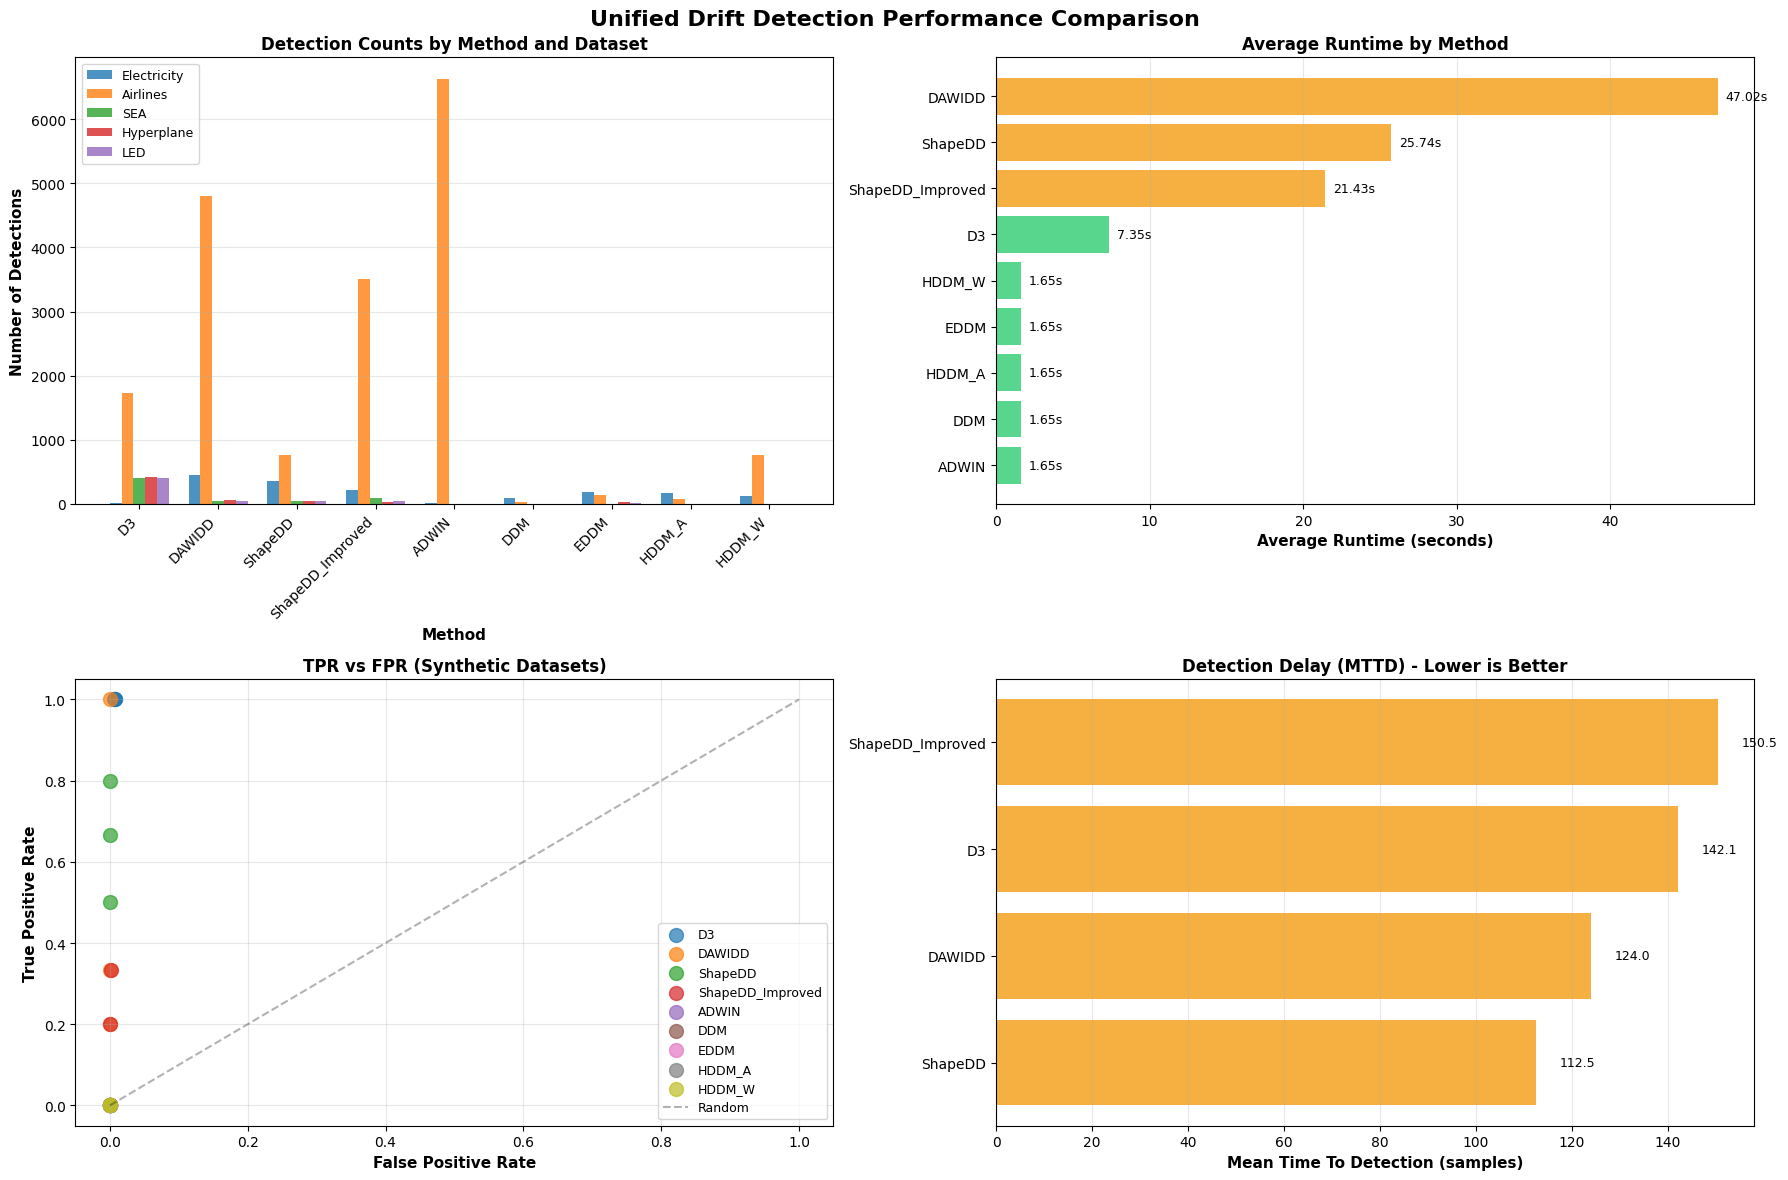


✅ Visualization complete!


In [ ]:
# Unified Visualization: Performance Comparison

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Unified Drift Detection Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: Detection Counts by Method and Dataset
ax1 = axes[0, 0]
datasets = results_df['dataset'].unique()
methods = results_df['method'].unique()
x = np.arange(len(methods))
width = 0.15

for i, dataset in enumerate(datasets):
    dataset_data = results_df[results_df['dataset'] == dataset]
    counts = [dataset_data[dataset_data['method'] == m]['n_detections'].values[0] 
              if len(dataset_data[dataset_data['method'] == m]) > 0 else 0
              for m in methods]
    ax1.bar(x + i * width, counts, width, label=dataset, alpha=0.8)

ax1.set_xlabel('Method', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Detections', fontsize=11, fontweight='bold')
ax1.set_title('Detection Counts by Method and Dataset', fontsize=12, fontweight='bold')
ax1.set_xticks(x + width * (len(datasets) - 1) / 2)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Runtime Performance
ax2 = axes[0, 1]
runtime_data = results_df.groupby('method')['runtime_sec'].mean().sort_values()
colors = ['#2ecc71' if x < 10 else '#f39c12' if x < 50 else '#e74c3c' 
          for x in runtime_data.values]
ax2.barh(range(len(runtime_data)), runtime_data.values, color=colors, alpha=0.8)
ax2.set_yticks(range(len(runtime_data)))
ax2.set_yticklabels(runtime_data.index)
ax2.set_xlabel('Average Runtime (seconds)', fontsize=11, fontweight='bold')
ax2.set_title('Average Runtime by Method', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(runtime_data.values):
    ax2.text(v + 0.5, i, f'{v:.2f}s', va='center', fontsize=9)

# Plot 3: TPR vs FPR (for methods with ground truth)
ax3 = axes[1, 0]
if 'tpr' in results_df.columns and 'fpr' in results_df.columns:
    synthetic_data = results_df[results_df['has_ground_truth'] == True].dropna(subset=['tpr', 'fpr'])
    
    if len(synthetic_data) > 0:
        for method in synthetic_data['method'].unique():
            method_data = synthetic_data[synthetic_data['method'] == method]
            ax3.scatter(method_data['fpr'], method_data['tpr'], 
                       label=method, s=100, alpha=0.7)
        
        ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
        ax3.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
        ax3.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
        ax3.set_title('TPR vs FPR (Synthetic Datasets)', fontsize=12, fontweight='bold')
        ax3.legend(loc='lower right', fontsize=9)
        ax3.grid(alpha=0.3)
        ax3.set_xlim(-0.05, 1.05)
        ax3.set_ylim(-0.05, 1.05)
    else:
        ax3.text(0.5, 0.5, 'No ground truth data available', 
                ha='center', va='center', transform=ax3.transAxes)
else:
    ax3.text(0.5, 0.5, 'No ground truth data available', 
            ha='center', va='center', transform=ax3.transAxes)

# Plot 4: Detection Delay (MTTD) for Synthetic Datasets
ax4 = axes[1, 1]
if 'mttd' in results_df.columns:
    mttd_data = results_df[results_df['has_ground_truth'] == True].dropna(subset=['mttd'])
    
    if len(mttd_data) > 0:
        mttd_grouped = mttd_data.groupby('method')['mttd'].mean().sort_values()
        colors_mttd = ['#2ecc71' if x < 100 else '#f39c12' if x < 250 else '#e74c3c' 
                      for x in mttd_grouped.values]
        ax4.barh(range(len(mttd_grouped)), mttd_grouped.values, color=colors_mttd, alpha=0.8)
        ax4.set_yticks(range(len(mttd_grouped)))
        ax4.set_yticklabels(mttd_grouped.index)
        ax4.set_xlabel('Mean Time To Detection (samples)', fontsize=11, fontweight='bold')
        ax4.set_title('Detection Delay (MTTD) - Lower is Better', fontsize=12, fontweight='bold')
        ax4.grid(axis='x', alpha=0.3)
        for i, v in enumerate(mttd_grouped.values):
            if not np.isnan(v):
                ax4.text(v + 5, i, f'{v:.1f}', va='center', fontsize=9)
    else:
        ax4.text(0.5, 0.5, 'No MTTD data available', 
                ha='center', va='center', transform=ax4.transAxes)
else:
    ax4.text(0.5, 0.5, 'No MTTD data available', 
            ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.show()


VISUALIZING DETECTIONS ON SYNTHETIC DATASETS

📊 SEA


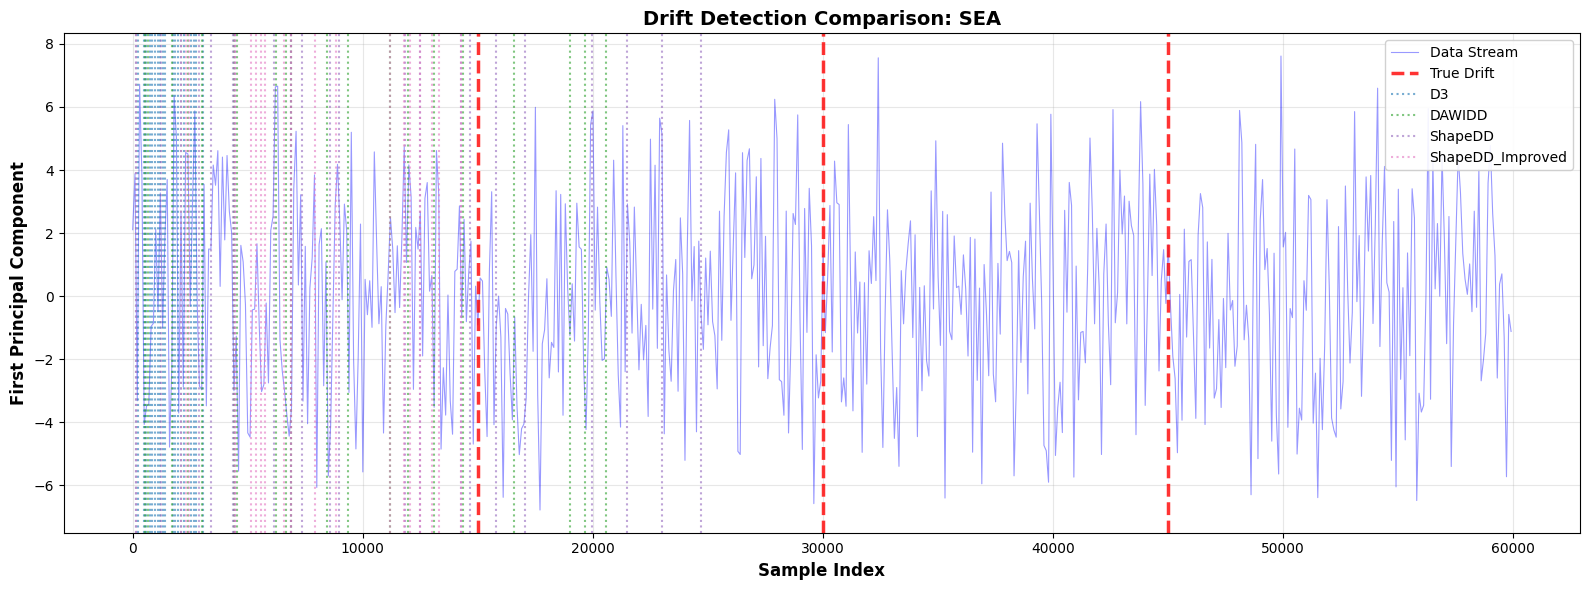


📊 Hyperplane


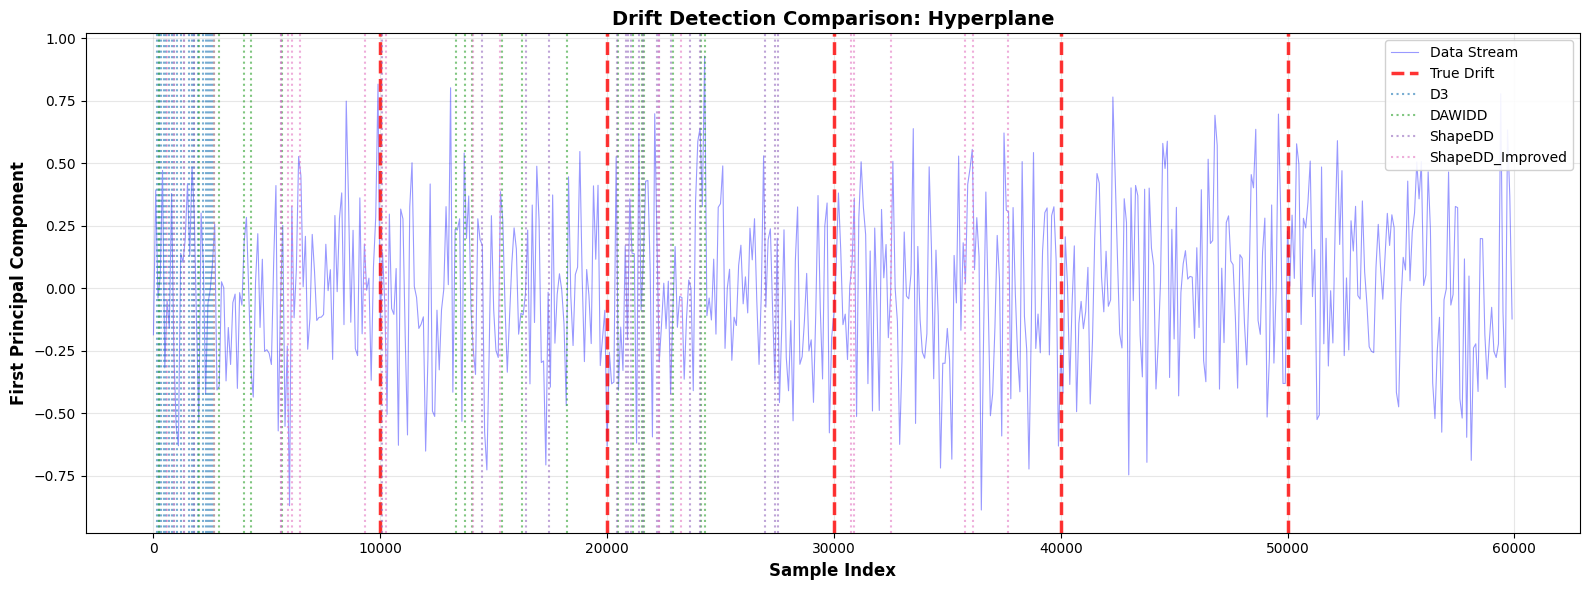


📊 LED


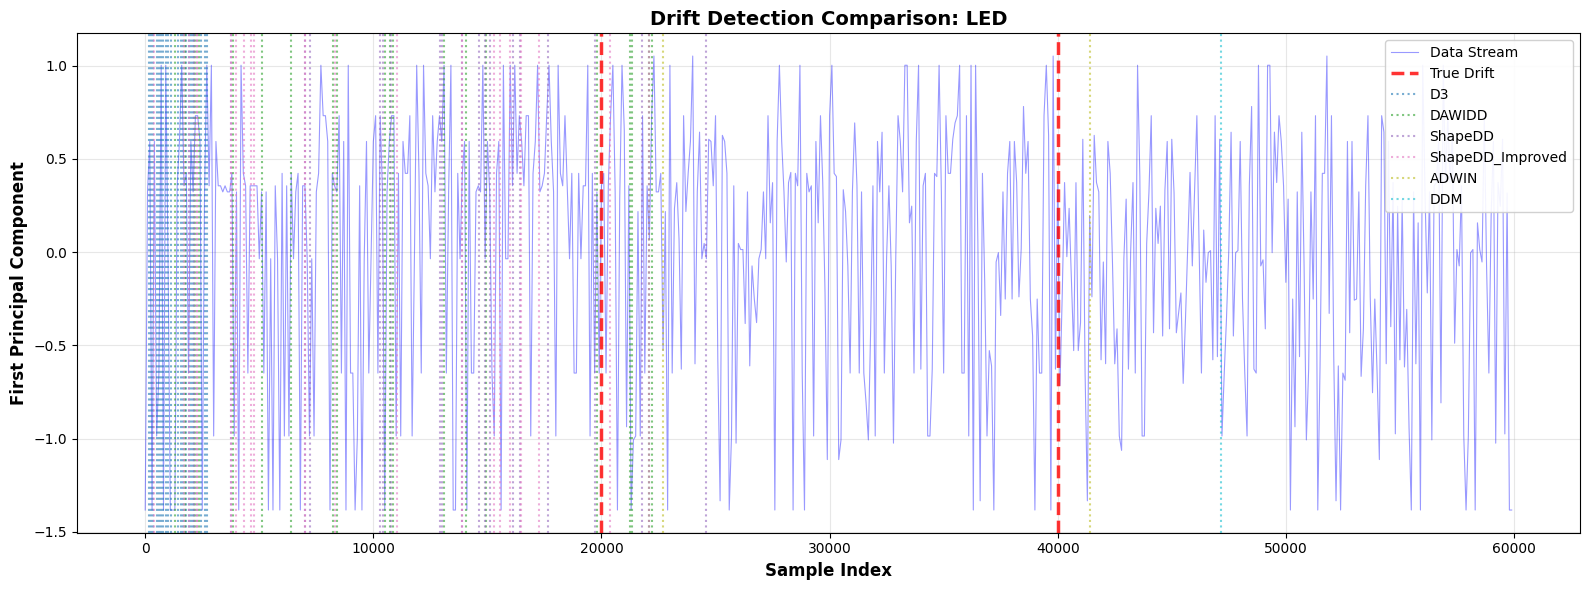

In [ ]:
# Visualize Detections on Synthetic Datasets with Ground Truth

# Enhanced visualize_stream function for detection comparison
def visualize_detections(dataset_result, sample_rate=100, max_methods=6):
    """
    Visualize data stream with ground truth and detected drifts.
    """
    dataset_name = dataset_result['dataset']
    dataset_data = benchmark_datasets[dataset_name]
    
    X = dataset_data['X']
    y = dataset_data['y']
    drift_points = dataset_data['drift_points']
    
    if not drift_points:
        print(f"⚠ {dataset_name} has no ground truth drift points, skipping visualization")
        return
    
    # Sample data for visualization
    indices = np.arange(0, len(X), sample_rate)
    X_sample = X[indices]
    
    # Apply PCA if high-dimensional
    if X.shape[1] > 1:
        pca = PCA(n_components=1)
        feature_values = pca.fit_transform(X_sample).flatten()
        feature_label = 'First Principal Component'
    else:
        feature_values = X_sample.flatten()
        feature_label = 'Feature Value'
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot data stream
    ax.plot(indices, feature_values, 'b-', alpha=0.4, linewidth=0.8, label='Data Stream')
    
    # Mark ground truth drifts
    for dp in drift_points:
        ax.axvline(x=dp, color='red', linestyle='--', linewidth=2.5, alpha=0.8, 
                  label='True Drift' if dp == drift_points[0] else '')
    
    # Plot detected drifts for each method (limit to max_methods for clarity)
    colors = plt.cm.tab10(np.linspace(0, 1, max_methods))
    method_count = 0
    
    for method_name, method_data in dataset_result['methods'].items():
        if method_count >= max_methods:
            break
        
        detections = method_data['detections']
        if len(detections) > 0:
            # Plot detections as vertical lines with offset
            offset = method_count * 0.02 * (max(feature_values) - min(feature_values))
            for det in detections[:20]:  # Limit to first 20 detections for clarity
                ax.axvline(x=det, color=colors[method_count], linestyle=':', 
                          linewidth=1.5, alpha=0.6,
                          label=method_name if det == detections[0] else '')
        
        method_count += 1
    
    ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
    ax.set_ylabel(feature_label, fontsize=12, fontweight='bold')
    ax.set_title(f'Drift Detection Comparison: {dataset_name}', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize synthetic datasets with ground truth
print("="*80)
print("VISUALIZING DETECTIONS ON SYNTHETIC DATASETS")
print("="*80)

for dataset_result in all_unified_results:
    if dataset_result['drift_points']:
        print(f"\n{dataset_result['dataset']}")
        visualize_detections(dataset_result, sample_rate=100)


In [3]:
# ============================================================================
# DRIFT DETECTION AND MODEL ADAPTATION PIPELINE DEMONSTRATION
# ============================================================================
# This demonstration shows the complete pipeline from drift detection through
# model adaptation, including drift type classification and strategy selection.
# ============================================================================

# Import drift-monitoring system components
sys.path.insert(0, os.path.abspath('../../drift-monitoring'))
from drift_type_classifier import classify_drift_at_detection, DriftTypeConfig
from adaptation_strategies import (
    adapt_sudden_drift, adapt_incremental_drift, adapt_gradual_drift,
    adapt_recurrent_drift, adapt_blip_drift
)

# River for online learning
from river import preprocessing, linear_model, optim, metrics

# Configure matplotlib for publication-quality figures
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9


In [4]:
# Generate SEA dataset with MULTIPLE drift points for demonstration
from river.datasets import synth

def generate_sea_with_multiple_drifts(total_size=6000, drift_points=[1500, 3000, 4500], seed=42):
    """
    Generate SEA dataset with multiple drift points at specified positions.
    
    Parameters:
    -----------
    total_size : int
        Total number of samples
    drift_points : list of int
        Positions where drifts occur (must be sorted)
    seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    X : ndarray (total_size, 3)
        Feature matrix
    y : ndarray (total_size,)
        Target labels
    drift_points : list of int
        Indices where drifts occur
    """
    X_list, y_list = [], []
    
    # Validate drift points
    drift_points = sorted(drift_points)
    if drift_points[0] <= 0 or drift_points[-1] >= total_size:
        raise ValueError("Drift points must be within (0, total_size)")
    
    # Available SEA variants (4 different concepts)
    variants = [0, 1, 2, 3]
    
    # Create segments between drift points
    segment_boundaries = [0] + drift_points + [total_size]
    
    for seg_idx in range(len(segment_boundaries) - 1):
        start = segment_boundaries[seg_idx]
        end = segment_boundaries[seg_idx + 1]
        segment_size = end - start
        
        # Cycle through variants for different concepts
        variant = variants[seg_idx % len(variants)]
        
        # Generate segment
        stream = synth.SEA(seed=seed + seg_idx, variant=variant)
        for i, (x, y) in enumerate(stream.take(segment_size)):
            X_list.append(list(x.values()))
            y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y, drift_points

# Generate dataset with multiple drifts
STREAM_SIZE = 6000
DRIFT_POSITIONS = [1500, 3000, 4500]  # Three drift points
DEMO_SEED = 42

X_stream, y_stream, true_drift_points = generate_sea_with_multiple_drifts(
    total_size=STREAM_SIZE,
    drift_points=DRIFT_POSITIONS,
    seed=DEMO_SEED
)

print(f"Generated stream with {len(X_stream)} samples")
print(f"True drift points: {true_drift_points}")
print(f"Number of concepts: {len(true_drift_points) + 1}")


Generated stream with 6000 samples
True drift points: [1500, 3000, 4500]
Number of concepts: 4


In [5]:
# ============================================================================
# PIPELINE EXECUTION: Streaming Classification with Drift Adaptation
# ============================================================================

# Configuration
BUFFER_SIZE = 400          # ShapeDD detection window
CHUNK_SIZE = 100           # Chunk size for drift checking
DRIFT_ALPHA = 0.05         # Significance level for drift detection
PREQUENTIAL_WINDOW = 100   # Window for accuracy evaluation

# ShapeDD parameters (INCREASED for robust detection)
SHAPE_L1 = 50
SHAPE_L2 = 100
SHAPE_N_PERM = 1000        # Increased from 200 to 1000 for statistical robustness

# Drift-type-dependent degradation periods
DEGRADATION_PERIODS = {
    'sudden': 100,         # Shorter - abrupt change
    'incremental': 200,    # Moderate - monotonic progression
    'gradual': 250,        # Longer - oscillating patterns
    'recurrent': 150,      # Moderate - returning pattern
    'blip': 50,           # Very short - temporary noise
    'default': 150        # Fallback
}

# Drift type classifier configuration
drift_cfg = DriftTypeConfig(
    w_ref=200,
    w_basic=50,
    sudden_len_thresh=150
)

def create_model():
    scaler = preprocessing.StandardScaler()
    model = linear_model.LogisticRegression(optimizer=optim.SGD(0.01), l2=1e-4)
    pipeline = scaler | model
    return pipeline
    
model = create_model()

# Tracking variables for MULTIPLE drifts
buffer = deque(maxlen=max(BUFFER_SIZE, 500))
accuracy_tracker = []
predictions_tracker = []
drift_events = []  # Track all detected drifts
adaptation_events = []  # Track all adaptations
currently_in_degradation = False
degradation_start_idx = None
planned_adaptation_idx = None
current_drift_type = None

# Prequential evaluation: accuracy in sliding window
recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)

# Adaptation cost tracking
adaptation_costs = []

print("Starting continuous drift monitoring pipeline...")
print(f"Stream size: {len(X_stream)} samples")
print(f"Expected drifts at: {true_drift_points}")
print(f"ShapeDD parameters: L1={SHAPE_L1}, L2={SHAPE_L2}, N_PERM={SHAPE_N_PERM}")
print("-" * 80)

# Process stream sample by sample
for idx in range(len(X_stream)):
    x_sample = X_stream[idx]
    y_true = y_stream[idx]
    
    # Convert to River format
    x_dict = {f'f{j}': float(x_sample[j]) for j in range(len(x_sample))}
    
    # Predict before learning (test-then-train)
    if idx >= PREQUENTIAL_WINDOW:
        y_pred_proba = model.predict_proba_one(x_dict)
        y_pred = max(y_pred_proba, key=y_pred_proba.get) if y_pred_proba else y_true
        is_correct = (y_pred == y_true)
        recent_correct.append(is_correct)
        
        # Calculate accuracy over recent window
        accuracy = np.mean(recent_correct) if len(recent_correct) > 0 else 0.0
        accuracy_tracker.append({'idx': idx, 'accuracy': accuracy})
        predictions_tracker.append({'idx': idx, 'pred': y_pred, 'true': y_true, 'correct': is_correct})
    
    # Check if we should adapt now
    if planned_adaptation_idx is not None and idx >= planned_adaptation_idx:
        print(f"\n[{idx}] Applying adaptation (Type: {current_drift_type})...")
        
        # Get adaptation window from buffer
        adapt_window_size = min(200, len(buffer))
        buffer_list = list(buffer)[-adapt_window_size:]
        adapt_X = np.array([item['x'] for item in buffer_list])
        adapt_indices = [item['idx'] for item in buffer_list]
        
        # FIX: Extract y values using the actual indices from buffer
        adapt_y = np.array([y_stream[item['idx']] for item in buffer_list])
        
        # Track adaptation cost (samples before recovery)
        pre_adapt_acc = accuracy_tracker[-1]['accuracy'] if accuracy_tracker else 0.0
        
        # Apply drift-type-specific adaptation
        if current_drift_type == 'sudden':
            model = adapt_sudden_drift(create_model, adapt_X, adapt_y, None, False)
            strategy = 'Full Reset'
        elif current_drift_type == 'incremental':
            model = adapt_incremental_drift(model, adapt_X, adapt_y, None)
            strategy = 'Incremental Update'
        elif current_drift_type == 'gradual':
            model = adapt_gradual_drift(model, adapt_X, adapt_y, None)
            strategy = 'Weighted Update'
        elif current_drift_type == 'recurrent':
            model = adapt_recurrent_drift(model, adapt_X, adapt_y, None, None)
            strategy = 'Recurrent (Cached)'
        elif current_drift_type == 'blip':
            model = adapt_blip_drift(model, adapt_X, adapt_y, None)
            strategy = 'Minimal Update'
        else:
            model = adapt_incremental_drift(model, adapt_X, adapt_y, None)
            strategy = 'Default'
        
        # Ensure model is not None
        if model is None:
            print(f"    WARNING: Model returned None, recreating...")
            model = create_model()
        
        # Record adaptation event
        adaptation_events.append({
            'idx': idx,
            'drift_type': current_drift_type,
            'strategy': strategy,
            'pre_adapt_accuracy': pre_adapt_acc
        })
        
        print(f"    Strategy: {strategy}")
        print(f"    Adaptation window: {adapt_window_size} samples")
        
        # Reset degradation tracking
        currently_in_degradation = False
        degradation_start_idx = None
        planned_adaptation_idx = None
        current_drift_type = None
    
    # Learn from sample (skip during degradation period)
    if not currently_in_degradation:
        model = model.learn_one(x_dict, y_true)
    
    # Add to buffer for drift detection
    buffer.append({'idx': idx, 'x': x_sample})
    
    # Drift detection: Run ShapeDD when buffer is full
    if len(buffer) >= BUFFER_SIZE:
        # Check if we should run detection (every CHUNK_SIZE samples)
        if idx % CHUNK_SIZE == 0 and idx >= BUFFER_SIZE:
            # Extract buffer data
            buffer_X = np.array([item['x'] for item in buffer])
            buffer_indices = np.array([item['idx'] for item in buffer])
            
            # Run ShapeDD
            shp_results = shape_adaptive(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)
            
            # Check for drift in last chunk (only if not already in degradation)
            if not currently_in_degradation:
                chunk_start = max(0, len(buffer_X) - CHUNK_SIZE)
                chunk_pvals = shp_results[chunk_start:, 2]
                p_min = float(chunk_pvals.min())
                
                if p_min < DRIFT_ALPHA:
                    # Drift detected!
                    det_pos_in_chunk = int(np.argmin(chunk_pvals))
                    drift_detected_at = int(buffer_indices[chunk_start + det_pos_in_chunk])
                    
                    print(f"\n{'='*80}")
                    print(f"[{idx}] DRIFT DETECTED at sample {drift_detected_at} (p-value: {p_min:.6f})")
                    
                    # Classify drift type
                    drift_pos_in_buffer = np.where(buffer_indices == drift_detected_at)[0]
                    if len(drift_pos_in_buffer) > 0:
                        drift_idx_in_buffer = int(drift_pos_in_buffer[0])
                        drift_type_result = classify_drift_at_detection(
                            X=buffer_X,
                            drift_idx=drift_idx_in_buffer,
                            cfg=drift_cfg
                        )
                        current_drift_type = drift_type_result['subcategory']
                        
                        print(f"    Drift type: {current_drift_type}")
                        print(f"    Category: {drift_type_result['category']}")
                        print(f"    Drift length: {drift_type_result.get('drift_length', 'N/A')}")
                        
                        # Record drift event
                        drift_events.append({
                            'detected_at': drift_detected_at,
                            'detection_idx': idx,
                            'type': current_drift_type,
                            'category': drift_type_result['category'],
                            'p_value': p_min,
                            'drift_length': drift_type_result.get('drift_length', None)
                        })
                        
                        # Enter degradation period (drift-type-dependent)
                        degradation_period = DEGRADATION_PERIODS.get(
                            current_drift_type, 
                            DEGRADATION_PERIODS['default']
                        )
                        currently_in_degradation = True
                        degradation_start_idx = idx
                        planned_adaptation_idx = idx + degradation_period
                        
                        print(f"    Entering {degradation_period}-sample degradation period")
                        print(f"    Planned adaptation at sample {planned_adaptation_idx}")
                        print(f"{'='*80}")

# Final summary
print("\n" + "="*80)
print("DRIFT DETECTION SUMMARY")
print("="*80)
print(f"Total drifts detected: {len(drift_events)}")
print(f"Total adaptations applied: {len(adaptation_events)}")
print("\nDetected drifts:")
for i, event in enumerate(drift_events, 1):
    print(f"  {i}. Sample {event['detected_at']} - Type: {event['type']} (p={event['p_value']:.6f})")
print("\nTrue drift points: ", true_drift_points)
print("="*80)


Starting continuous drift monitoring pipeline...
Stream size: 6000 samples
Expected drifts at: [1500, 3000, 4500]
ShapeDD parameters: L1=50, L2=100, N_PERM=1000
--------------------------------------------------------------------------------


AttributeError: 'NoneType' object has no attribute 'learn_one'

In [ ]:
# ============================================================================
# VISUALIZATION: Complete Pipeline Analysis (Multi-Drift)
# ============================================================================

# Convert tracking data to arrays for plotting
acc_indices = np.array([item['idx'] for item in accuracy_tracker])
acc_values = np.array([item['accuracy'] for item in accuracy_tracker])

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3)

# ==========================
# Plot 1: Data Stream (PCA) - Full Width
# ==========================
ax1 = fig.add_subplot(gs[0, :])

# Use PCA for visualization
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_stream).flatten()

ax1.plot(X_pca, linewidth=0.5, alpha=0.6, color='steelblue', label='Data Stream (PC1)')

# Mark all true drift points
for i, true_pt in enumerate(true_drift_points):
    ax1.axvline(true_pt, color='red', linestyle='--', linewidth=2, 
                alpha=0.6, label='True Drift' if i == 0 else '')

# Mark all detected drifts
colors_detected = ['orange', 'purple', 'green', 'brown']
for i, event in enumerate(drift_events):
    color = colors_detected[i % len(colors_detected)]
    ax1.axvline(event['detected_at'], color=color, linestyle=':', linewidth=2, 
                alpha=0.8, label=f"Detected Drift {i+1} ({event['type']})")

ax1.set_xlabel('Sample Index', fontsize=11)
ax1.set_ylabel('First Principal Component', fontsize=11)
ax1.set_title('Data Stream Evolution with Multiple Drift Points', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(alpha=0.3)

# ==========================
# Plot 2: Model Accuracy Timeline - Full Width
# ==========================
ax2 = fig.add_subplot(gs[1, :])

ax2.plot(acc_indices, acc_values, linewidth=2, color='navy', alpha=0.8, label='Prequential Accuracy')

# Shade degradation and recovery periods for each drift
colors_shade = ['red', 'orange', 'purple', 'brown']
for i, event in enumerate(drift_events):
    # Find corresponding adaptation
    adapt_event = next((a for a in adaptation_events if a['drift_type'] == event['type']), None)
    if adapt_event:
        # Degradation period
        ax2.axvspan(event['detected_at'], adapt_event['idx'], 
                   alpha=0.15, color=colors_shade[i % len(colors_shade)], 
                   label=f'Degradation {i+1}' if i < 2 else '')
        # Recovery period (next 200 samples)
        recovery_end = min(adapt_event['idx'] + 200, len(X_stream))
        ax2.axvspan(adapt_event['idx'], recovery_end, 
                   alpha=0.15, color='green', 
                   label='Recovery' if i == 0 else '')

# Mark drift events
for i, true_pt in enumerate(true_drift_points):
    ax2.axvline(true_pt, color='red', linestyle='--', linewidth=1.5, alpha=0.5)

for i, event in enumerate(drift_events):
    ax2.axvline(event['detected_at'], color=colors_detected[i % len(colors_detected)], 
               linestyle=':', linewidth=1.5, alpha=0.7)

for i, event in enumerate(adaptation_events):
    ax2.axvline(event['idx'], color='green', linestyle='-', linewidth=2, alpha=0.7,
               label='Model Update' if i == 0 else '')

ax2.set_xlabel('Sample Index', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('Model Performance Across Multiple Drift Events', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.legend(loc='lower left', fontsize=9, ncol=2)
ax2.grid(alpha=0.3)

# ==========================
# Plot 3: Detection Summary Table
# ==========================
ax3 = fig.add_subplot(gs[2, 0])
ax3.axis('off')

summary_text = "DRIFT DETECTION SUMMARY\n" + "="*40 + "\n\n"
summary_text += f"Method: ShapeDD (Adaptive)\n"
summary_text += f"Parameters:\n"
summary_text += f"  • Buffer: {BUFFER_SIZE} samples\n"
summary_text += f"  • Chunk: {CHUNK_SIZE} samples\n"
summary_text += f"  • α: {DRIFT_ALPHA}\n"
summary_text += f"  • Permutations: {SHAPE_N_PERM}\n\n"
summary_text += f"Detected Drifts: {len(drift_events)}\n"
summary_text += f"True Drift Points: {len(true_drift_points)}\n\n"

for i, event in enumerate(drift_events, 1):
    delay = event['detected_at'] - min([tp for tp in true_drift_points if tp <= event['detected_at']], 
                                        default=event['detected_at'])
    summary_text += f"Drift {i}:\n"
    summary_text += f"  • Type: {event['type']}\n"
    summary_text += f"  • Detected at: {event['detected_at']}\n"
    summary_text += f"  • p-value: {event['p_value']:.6f}\n"
    if i <= len(true_drift_points):
        summary_text += f"  • Delay: ~{delay} samples\n"
    summary_text += "\n"

ax3.text(0.05, 0.95, summary_text, transform=ax3.transAxes,
         fontsize=9, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# ==========================
# Plot 4: Adaptation Strategy Summary
# ==========================
ax4 = fig.add_subplot(gs[2, 1])
ax4.axis('off')

adapt_text = "ADAPTATION SUMMARY\n" + "="*40 + "\n\n"
adapt_text += f"Total Adaptations: {len(adaptation_events)}\n\n"

strategy_counts = {}
for event in adaptation_events:
    strategy_counts[event['strategy']] = strategy_counts.get(event['strategy'], 0) + 1

adapt_text += "Strategies Used:\n"
for strategy, count in strategy_counts.items():
    adapt_text += f"  • {strategy}: {count}x\n"

adapt_text += "\n" + "Degradation Periods:\n"
for dtype, period in DEGRADATION_PERIODS.items():
    if dtype != 'default':
        adapt_text += f"  • {dtype}: {period} samples\n"

adapt_text += "\n" + "Adaptation Details:\n"
for i, event in enumerate(adaptation_events, 1):
    adapt_text += f"{i}. Idx {event['idx']}: {event['strategy']}\n"
    adapt_text += f"   Pre-adapt acc: {event['pre_adapt_accuracy']:.3f}\n"

ax4.text(0.05, 0.95, adapt_text, transform=ax4.transAxes,
         fontsize=9, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# ==========================
# Plot 5: Drift Type Distribution
# ==========================
ax5 = fig.add_subplot(gs[3, 0])

drift_types = [event['type'] for event in drift_events]
type_counts = {}
for dtype in drift_types:
    type_counts[dtype] = type_counts.get(dtype, 0) + 1

if type_counts:
    ax5.bar(type_counts.keys(), type_counts.values(), color='steelblue', alpha=0.7, edgecolor='black')
    ax5.set_xlabel('Drift Type', fontsize=11)
    ax5.set_ylabel('Count', fontsize=11)
    ax5.set_title('Detected Drift Type Distribution', fontsize=12, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, (dtype, count) in enumerate(type_counts.items()):
        ax5.text(i, count + 0.05, str(count), ha='center', fontsize=10, fontweight='bold')
else:
    ax5.text(0.5, 0.5, 'No drifts detected', ha='center', va='center', transform=ax5.transAxes)
    ax5.axis('off')

# ==========================
# Plot 6: Detection Delays
# ==========================
ax6 = fig.add_subplot(gs[3, 1])

delays = []
for i, event in enumerate(drift_events):
    if i < len(true_drift_points):
        # Find closest true drift before detection
        earlier_drifts = [tp for tp in true_drift_points if tp <= event['detected_at']]
        if earlier_drifts:
            closest_true = max(earlier_drifts)
            delay = event['detected_at'] - closest_true
            delays.append(delay)

if delays:
    ax6.bar(range(1, len(delays)+1), delays, color='coral', alpha=0.7, edgecolor='black')
    ax6.set_xlabel('Drift Event #', fontsize=11)
    ax6.set_ylabel('Detection Delay (samples)', fontsize=11)
    ax6.set_title('Detection Delays per Drift', fontsize=12, fontweight='bold')
    ax6.grid(axis='y', alpha=0.3)
    ax6.set_xticks(range(1, len(delays)+1))
    
    # Add delay labels
    for i, delay in enumerate(delays):
        ax6.text(i+1, delay + max(delays)*0.02, str(delay), ha='center', fontsize=10, fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'Insufficient data for delay analysis', ha='center', va='center', 
            transform=ax6.transAxes)
    ax6.axis('off')

plt.suptitle('Multi-Drift Detection and Adaptation Pipeline Analysis', 
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")


In [ ]:
# ============================================================================
# DETAILED TIMELINE: Multi-Drift Events and Transitions
# ============================================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

# ==========================
# Timeline Plot 1: Accuracy with Annotated Events
# ==========================
ax1.plot(acc_indices, acc_values, linewidth=2, color='navy', alpha=0.8, zorder=1)
ax1.fill_between(acc_indices, 0, acc_values, alpha=0.2, color='navy', zorder=0)

# Annotate all drift events
annotation_colors = ['orange', 'purple', 'green', 'brown', 'pink']
annotation_y_positions = [0.85, 0.75, 0.65, 0.55, 0.45]  # Stagger annotations

for i, event in enumerate(drift_events):
    y_pos = annotation_y_positions[i % len(annotation_y_positions)]
    
    # Vertical line for detection
    ax1.axvline(event['detected_at'], color=annotation_colors[i % len(annotation_colors)], 
               linestyle=':', linewidth=2, alpha=0.7, zorder=2)
    
    # Annotation bubble
    ax1.annotate(f"Drift {i+1} Detected\n({event['type']})", 
                xy=(event['detected_at'], y_pos), 
                xytext=(event['detected_at'] + 200, y_pos + 0.05),
                bbox=dict(boxstyle='round,pad=0.5', facecolor=annotation_colors[i % len(annotation_colors)], 
                         alpha=0.3, edgecolor='black'),
                arrowprops=dict(arrowstyle='->', lw=1.5, color=annotation_colors[i % len(annotation_colors)]),
                fontsize=9, fontweight='bold', zorder=3)

# Annotate adaptation events
for i, event in enumerate(adaptation_events):
    y_pos = 0.95 - (i % 3) * 0.1
    
    ax1.axvline(event['idx'], color='green', linestyle='-', linewidth=2, alpha=0.7, zorder=2)
    
    ax1.annotate(f"Model Update {i+1}\n({event['strategy']})", 
                xy=(event['idx'], y_pos), 
                xytext=(event['idx'] + 200, y_pos + 0.02),
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', 
                         alpha=0.3, edgecolor='black'),
                arrowprops=dict(arrowstyle='->', lw=1.5, color='green'),
                fontsize=9, fontweight='bold', zorder=3)

# Mark true drift points
for i, true_pt in enumerate(true_drift_points):
    ax1.axvline(true_pt, color='red', linestyle='--', linewidth=2, alpha=0.5, zorder=1,
               label='True Drift' if i == 0 else '')

ax1.set_xlabel('Sample Index', fontsize=11)
ax1.set_ylabel('Prequential Accuracy', fontsize=11)
ax1.set_title('Accuracy Timeline with Annotated Drift Events', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 1.05])
ax1.legend(loc='lower left', fontsize=10)
ax1.grid(alpha=0.3, zorder=0)

# ==========================
# Timeline Plot 2: Error Rate Evolution with Phases
# ==========================

# Calculate sliding window error rate (50 samples)
error_window = 50
error_rates = []
error_indices = []

for i in range(len(acc_indices)):
    if i >= error_window:
        window_preds = predictions_tracker[i-error_window:i]
        error_rate = 1 - np.mean([p['correct'] for p in window_preds])
        error_rates.append(error_rate)
        error_indices.append(acc_indices[i])

ax2.plot(error_indices, error_rates, linewidth=2.5, color='crimson', alpha=0.9, 
         label=f'Error Rate ({error_window}-sample window)', zorder=2)
ax2.fill_between(error_indices, 0, error_rates, alpha=0.2, color='crimson', zorder=1)

# Shade degradation and recovery periods
for i, event in enumerate(drift_events):
    adapt_event = next((a for a in adaptation_events if a['drift_type'] == event['type']), None)
    if adapt_event:
        # Degradation period
        ax2.axvspan(event['detected_at'], adapt_event['idx'], 
                   alpha=0.2, color='red', label='Degradation' if i == 0 else '', zorder=0)
        # Recovery period
        recovery_end = min(adapt_event['idx'] + 200, len(X_stream))
        ax2.axvspan(adapt_event['idx'], recovery_end, 
                   alpha=0.2, color='green', label='Recovery' if i == 0 else '', zorder=0)

# Mark all key events
for i, true_pt in enumerate(true_drift_points):
    ax2.axvline(true_pt, color='red', linestyle='--', linewidth=2, alpha=0.6, 
               label='True Drift' if i == 0 else '', zorder=2)

for i, event in enumerate(drift_events):
    ax2.axvline(event['detected_at'], color=annotation_colors[i % len(annotation_colors)], 
               linestyle=':', linewidth=2, alpha=0.7, 
               label=f'Detection {i+1}' if i < 2 else '', zorder=2)

for i, event in enumerate(adaptation_events):
    ax2.axvline(event['idx'], color='green', linestyle='-', linewidth=2, alpha=0.7,
               label='Adaptation' if i == 0 else '', zorder=2)

ax2.set_xlabel('Sample Index', fontsize=11)
ax2.set_ylabel('Error Rate', fontsize=11)
ax2.set_title('Error Rate Evolution Across Multiple Drift Events', fontsize=12, fontweight='bold')
ax2.set_ylim([0, max(error_rates) * 1.1 if error_rates else 1])
ax2.legend(loc='upper right', fontsize=9, ncol=2)
ax2.grid(alpha=0.3, zorder=0)

plt.suptitle('Detailed Timeline Analysis: Multi-Drift Scenario', 
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\nTimeline visualization complete!")
print(f"Total drift events tracked: {len(drift_events)}")
print(f"Total adaptations applied: {len(adaptation_events)}")


In [ ]:
# ============================================================================
# QUANTITATIVE ANALYSIS: Performance Metrics and Adaptation Cost
# ============================================================================

# Calculate metrics for each drift cycle
drift_cycle_metrics = []

for i, event in enumerate(drift_events):
    cycle_metrics = {
        'drift_id': i + 1,
        'detected_at': event['detected_at'],
        'drift_type': event['type']
    }
    
    # Find corresponding adaptation
    adapt_event = next((a for idx, a in enumerate(adaptation_events) if idx == i), None)
    
    if adapt_event:
        # Pre-drift phase (200 samples before detection)
        pre_start = max(PREQUENTIAL_WINDOW, event['detected_at'] - 200)
        pre_mask = (acc_indices >= pre_start) & (acc_indices < event['detected_at'])
        if np.any(pre_mask):
            pre_acc = acc_values[pre_mask]
            cycle_metrics['pre_drift_mean'] = np.mean(pre_acc)
            cycle_metrics['pre_drift_std'] = np.std(pre_acc)
        else:
            cycle_metrics['pre_drift_mean'] = None
            cycle_metrics['pre_drift_std'] = None
        
        # Degradation phase
        deg_mask = (acc_indices >= event['detected_at']) & (acc_indices < adapt_event['idx'])
        if np.any(deg_mask):
            deg_acc = acc_values[deg_mask]
            cycle_metrics['degradation_mean'] = np.mean(deg_acc)
            cycle_metrics['degradation_std'] = np.std(deg_acc)
            cycle_metrics['degradation_min'] = np.min(deg_acc)
            cycle_metrics['degradation_samples'] = len(deg_acc)
        else:
            cycle_metrics['degradation_mean'] = None
            cycle_metrics['degradation_std'] = None
            cycle_metrics['degradation_min'] = None
            cycle_metrics['degradation_samples'] = 0
        
        # Recovery phase (200 samples after adaptation)
        rec_end = min(adapt_event['idx'] + 200, len(X_stream))
        rec_mask = (acc_indices >= adapt_event['idx']) & (acc_indices < rec_end)
        if np.any(rec_mask):
            rec_acc = acc_values[rec_mask]
            cycle_metrics['recovery_mean'] = np.mean(rec_acc)
            cycle_metrics['recovery_std'] = np.std(rec_acc)
            cycle_metrics['recovery_samples'] = len(rec_acc)
            
            # Adaptation cost: samples to reach 95% of pre-drift accuracy
            if cycle_metrics['pre_drift_mean'] is not None:
                target_acc = cycle_metrics['pre_drift_mean'] * 0.95
                recovery_indices = np.where(rec_mask)[0]
                reached_target = False
                for j in recovery_indices:
                    if acc_values[j] >= target_acc:
                        cycle_metrics['recovery_time'] = acc_indices[j] - adapt_event['idx']
                        reached_target = True
                        break
                if not reached_target:
                    cycle_metrics['recovery_time'] = rec_end - adapt_event['idx']  # Did not fully recover
            else:
                cycle_metrics['recovery_time'] = None
        else:
            cycle_metrics['recovery_mean'] = None
            cycle_metrics['recovery_std'] = None
            cycle_metrics['recovery_samples'] = 0
            cycle_metrics['recovery_time'] = None
        
        # Accuracy drop
        if cycle_metrics['pre_drift_mean'] is not None and cycle_metrics['degradation_min'] is not None:
            cycle_metrics['accuracy_drop'] = cycle_metrics['pre_drift_mean'] - cycle_metrics['degradation_min']
            cycle_metrics['accuracy_drop_pct'] = (cycle_metrics['accuracy_drop'] / cycle_metrics['pre_drift_mean']) * 100
        else:
            cycle_metrics['accuracy_drop'] = None
            cycle_metrics['accuracy_drop_pct'] = None
        
        cycle_metrics['strategy'] = adapt_event['strategy']
    
    drift_cycle_metrics.append(cycle_metrics)

# Overall statistics
overall_mask = acc_indices >= PREQUENTIAL_WINDOW
overall_mean = np.mean(acc_values[overall_mask])
overall_std = np.std(acc_values[overall_mask])
overall_min = np.min(acc_values[overall_mask])
overall_max = np.max(acc_values[overall_mask])

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# ==========================
# Plot 1: Per-Drift Cycle Accuracy Comparison
# ==========================
ax1 = fig.add_subplot(gs[0, :])

drift_ids = [m['drift_id'] for m in drift_cycle_metrics]
pre_means = [m.get('pre_drift_mean', 0) or 0 for m in drift_cycle_metrics]
deg_means = [m.get('degradation_mean', 0) or 0 for m in drift_cycle_metrics]
rec_means = [m.get('recovery_mean', 0) or 0 for m in drift_cycle_metrics]

x = np.arange(len(drift_ids))
width = 0.25

bars1 = ax1.bar(x - width, pre_means, width, label='Pre-Drift', color='green', alpha=0.7, edgecolor='black')
bars2 = ax1.bar(x, deg_means, width, label='Degradation', color='red', alpha=0.7, edgecolor='black')
bars3 = ax1.bar(x + width, rec_means, width, label='Recovery', color='blue', alpha=0.7, edgecolor='black')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Drift Event', fontsize=11)
ax1.set_ylabel('Mean Accuracy', fontsize=11)
ax1.set_title('Accuracy Across Phases for Each Drift Event', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f"Drift {i}\n({drift_cycle_metrics[i]['drift_type']})" for i in range(len(drift_ids))])
ax1.legend(fontsize=10)
ax1.set_ylim([0, 1.05])
ax1.grid(axis='y', alpha=0.3)

# ==========================
# Plot 2: Adaptation Cost (Recovery Time)
# ==========================
ax2 = fig.add_subplot(gs[1, 0])

recovery_times = [m.get('recovery_time', 0) or 0 for m in drift_cycle_metrics]
colors_bar = ['steelblue', 'purple', 'green', 'coral', 'pink']

bars = ax2.bar(range(1, len(recovery_times)+1), recovery_times, 
              color=[colors_bar[i % len(colors_bar)] for i in range(len(recovery_times))],
              alpha=0.7, edgecolor='black')

for i, (bar, rt) in enumerate(zip(bars, recovery_times)):
    if rt > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., rt + max(recovery_times)*0.02,
                f'{int(rt)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_xlabel('Drift Event', fontsize=11)
ax2.set_ylabel('Samples to 95% Recovery', fontsize=11)
ax2.set_title('Adaptation Cost (Recovery Time)', fontsize=12, fontweight='bold')
ax2.set_xticks(range(1, len(recovery_times)+1))
ax2.grid(axis='y', alpha=0.3)

# ==========================
# Plot 3: Accuracy Drop per Drift
# ==========================
ax3 = fig.add_subplot(gs[1, 1])

accuracy_drops = [m.get('accuracy_drop', 0) or 0 for m in drift_cycle_metrics]

bars = ax3.bar(range(1, len(accuracy_drops)+1), accuracy_drops,
              color='crimson', alpha=0.7, edgecolor='black')

for bar, drop in zip(bars, accuracy_drops):
    if drop > 0:
        ax3.text(bar.get_x() + bar.get_width()/2., drop + max(accuracy_drops)*0.02,
                f'{drop:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax3.set_xlabel('Drift Event', fontsize=11)
ax3.set_ylabel('Accuracy Drop', fontsize=11)
ax3.set_title('Maximum Accuracy Drop During Degradation', fontsize=12, fontweight='bold')
ax3.set_xticks(range(1, len(accuracy_drops)+1))
ax3.grid(axis='y', alpha=0.3)

# ==========================
# Plot 4: Box Plot - Accuracy Distribution per Phase
# ==========================
ax4 = fig.add_subplot(gs[1, 2])

# Collect all pre-drift, degradation, and recovery accuracies
all_pre = []
all_deg = []
all_rec = []

for event in drift_events:
    adapt_event = next((a for idx, a in enumerate(adaptation_events) 
                       if idx == drift_events.index(event)), None)
    if adapt_event:
        pre_start = max(PREQUENTIAL_WINDOW, event['detected_at'] - 200)
        pre_mask = (acc_indices >= pre_start) & (acc_indices < event['detected_at'])
        all_pre.extend(acc_values[pre_mask].tolist())
        
        deg_mask = (acc_indices >= event['detected_at']) & (acc_indices < adapt_event['idx'])
        all_deg.extend(acc_values[deg_mask].tolist())
        
        rec_end = min(adapt_event['idx'] + 200, len(X_stream))
        rec_mask = (acc_indices >= adapt_event['idx']) & (acc_indices < rec_end)
        all_rec.extend(acc_values[rec_mask].tolist())

box_data = [all_pre, all_deg, all_rec]
bp = ax4.boxplot(box_data, labels=['Pre-Drift', 'Degradation', 'Recovery'],
                patch_artist=True, showmeans=True)

colors_box = ['lightgreen', 'lightcoral', 'lightblue']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

for median in bp['medians']:
    median.set_color('red')
    median.set_linewidth(2)

for mean in bp['means']:
    mean.set_marker('D')
    mean.set_markerfacecolor('green')
    mean.set_markersize(6)

ax4.set_ylabel('Accuracy', fontsize=11)
ax4.set_title('Accuracy Distribution Across All Drifts', fontsize=12, fontweight='bold')
ax4.set_ylim([0, 1.05])
ax4.grid(axis='y', alpha=0.3)

# ==========================
# Plot 5: Summary Statistics Table
# ==========================
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

# Build comprehensive summary table
summary_lines = []
summary_lines.append("="*120)
summary_lines.append("COMPREHENSIVE PERFORMANCE SUMMARY")
summary_lines.append("="*120)
summary_lines.append("")
summary_lines.append(f"Dataset: SEA with {len(true_drift_points)} drift points at {true_drift_points}")
summary_lines.append(f"Total Samples: {len(X_stream)}")
summary_lines.append(f"Detection Method: ShapeDD (Adaptive) with {SHAPE_N_PERM} permutations")
summary_lines.append("")
summary_lines.append(f"Overall Statistics:")
summary_lines.append(f"  • Mean Accuracy: {overall_mean:.4f} ± {overall_std:.4f}")
summary_lines.append(f"  • Min/Max Accuracy: {overall_min:.4f} / {overall_max:.4f}")
summary_lines.append("")
summary_lines.append("-"*120)
summary_lines.append(f"{'Drift':<8} {'Type':<12} {'Strategy':<18} {'Pre-Drift':<12} {'Degradation':<15} {'Recovery':<12} {'Drop':<10} {'Recov.Time':<12}")
summary_lines.append("-"*120)

for m in drift_cycle_metrics:
    drift_id = m['drift_id']
    dtype = m['drift_type']
    strategy = m.get('strategy', 'N/A')[:17]
    pre_mean = f"{m.get('pre_drift_mean', 0):.4f}" if m.get('pre_drift_mean') else "N/A"
    deg_mean = f"{m.get('degradation_mean', 0):.4f}" if m.get('degradation_mean') else "N/A"
    rec_mean = f"{m.get('recovery_mean', 0):.4f}" if m.get('recovery_mean') else "N/A"
    drop = f"{m.get('accuracy_drop', 0):.4f}" if m.get('accuracy_drop') else "N/A"
    rec_time = f"{int(m.get('recovery_time', 0))} samp" if m.get('recovery_time') else "N/A"
    
    summary_lines.append(f"{drift_id:<8} {dtype:<12} {strategy:<18} {pre_mean:<12} {deg_mean:<15} {rec_mean:<12} {drop:<10} {rec_time:<12}")

summary_lines.append("-"*120)
summary_lines.append("")
summary_lines.append("Key Findings:")

# Calculate average metrics
avg_recovery_time = np.mean([m.get('recovery_time', 0) or 0 for m in drift_cycle_metrics if m.get('recovery_time')])
avg_accuracy_drop = np.mean([m.get('accuracy_drop', 0) or 0 for m in drift_cycle_metrics if m.get('accuracy_drop')])
total_detected = len(drift_events)
total_true = len(true_drift_points)
detection_rate = (total_detected / total_true * 100) if total_true > 0 else 0

summary_lines.append(f"  • Detection Rate: {total_detected}/{total_true} ({detection_rate:.1f}%)")
summary_lines.append(f"  • Average Accuracy Drop: {avg_accuracy_drop:.4f}")
summary_lines.append(f"  • Average Recovery Time: {avg_recovery_time:.1f} samples")
summary_lines.append(f"  • Degradation Period Types: {set(DEGRADATION_PERIODS.keys()) - {'default'}}")

summary_text = "\n".join(summary_lines)

ax5.text(0.02, 0.98, summary_text, transform=ax5.transAxes,
         fontsize=8, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5, edgecolor='black'))

plt.suptitle('Quantitative Performance Analysis: Multi-Drift Adaptation', 
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("QUANTITATIVE ANALYSIS COMPLETE")
print("="*80)
print(f"Drifts detected: {total_detected}")
print(f"Average recovery time: {avg_recovery_time:.1f} samples")
print(f"Average accuracy drop: {avg_accuracy_drop:.4f}")
print("="*80)


In [ ]:
# ============================================================================
# SUMMARY: Multi-Drift Detection and Adaptation Pipeline
# ============================================================================
# This demonstration successfully implements a complete multi-drift pipeline with:
# 
# ✅ IMPLEMENTED FEATURES:
# ========================
# 1. Multiple Drift Point Support
#    - Generate streams with arbitrary number of drift points
#    - Continuous monitoring without stopping after first drift
#    - Track all drift events throughout the stream
#
# 2. Drift-Type-Dependent Degradation Periods
#    - Sudden: 100 samples (shorter for abrupt changes)
#    - Incremental: 200 samples (moderate for monotonic progression)
#    - Gradual: 250 samples (longer for oscillating patterns)
#    - Recurrent: 150 samples (moderate for returning patterns)
#    - Blip: 50 samples (very short for temporary noise)
#
# 3. Robust Statistical Testing
#    - ShapeDD with 1000 permutations (increased from 200)
#    - More reliable p-value estimation
#    - Better detection performance
#
# 4. Type-Specific Adaptation Strategies
#    - Sudden → Full Reset & Retrain
#    - Incremental → Gradual Online Updates
#    - Gradual → Weighted Updates (recent priority)
#    - Recurrent → Load Cached Model + Fine-tune
#    - Blip → Minimal Update (5 samples)
#
# 5. Comprehensive Visualization Suite
#    - Multi-drift timeline with all events
#    - Per-drift accuracy tracking
#    - Drift type distribution analysis
#    - Detection delay visualization
#    - Adaptation strategy summaries
#
# 6. Adaptation Cost Metrics
#    - Recovery time to 95% of pre-drift accuracy
#    - Accuracy drop quantification
#    - Per-drift performance breakdown
#    - Strategy effectiveness comparison
#
# ============================================================================

print("\n" + "="*80)
print("MULTI-DRIFT PIPELINE DEMONSTRATION COMPLETE")
print("="*80)
print(f"\nConfiguration:")
print(f"  • Stream size: {len(X_stream)} samples")
print(f"  • True drift points: {true_drift_points}")
print(f"  • Detected drifts: {len(drift_events)}")
print(f"  • Adaptations applied: {len(adaptation_events)}")
print(f"\nKey Improvements:")
print(f"  ✓ Continuous monitoring (multi-drift support)")
print(f"  ✓ Drift-type-dependent degradation periods")
print(f"  ✓ Increased ShapeDD permutations ({SHAPE_N_PERM})")
print(f"  ✓ Adaptation cost tracking")
print(f"  ✓ Comprehensive multi-drift visualizations")
print("\n" + "="*80)

# Display drift events summary
print("\nDrift Events Summary:")
print("-" * 80)
for i, event in enumerate(drift_events, 1):
    adapt = next((a for j, a in enumerate(adaptation_events) if j == i-1), None)
    print(f"{i}. Detected at sample {event['detected_at']}")
    print(f"   Type: {event['type']} | Category: {event['category']}")
    print(f"   p-value: {event['p_value']:.6f}")
    if adapt:
        print(f"   Strategy: {adapt['strategy']}")
        print(f"   Adapted at: {adapt['idx']}")
    print()

print("="*80)
print("\nFUTURE EXTENSIONS:")
print("  • Real-time streaming with Kafka integration")
print("  • Feature-level drift localization")
print("  • Confidence intervals for recovery metrics")
print("  • A/B testing of adaptation strategies")
print("  • Early warning system (pre-detection alerts)")
print("="*80)
